# Lab 2
_By Ostap Trush_

I trained everything on kaggle, so I was limited by that.
To get 0.7 I trained LORA on xlm-roberta-large with oversampling, and a small manual limit, more on thaat in the readme.

In [2]:
!pip install -q peft transformers[sentencepiece] datasets evaluate scikit-learn accelerate --no-deps
import pandas as pd
import numpy as np
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding
)
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset
import gc
import shutil
import os


2025-12-14 19:08:08.466457: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765739288.685195     173 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765739288.747746     173 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Raw Counts:
emotion                        Anger  Disgust  Fear  Happiness  Neutral  \
category                                                                  
Complaint / Dissatisfaction     1569       73    11          4       48   
Gratitude / Positive Feedback      0        0     0       5126       52   
Neutral Comment                    0        0     0         19      258   
Question / Request for Help        6        1    21          8      323   
Suggestion / Idea                 10        0     6        133      101   

emotion                        Sadness  Surprise  
category                                          
Complaint / Dissatisfaction        208         5  
Gratitude / Positive Feedback       12        20  
Neutral Comment                      6         6  
Question / Request for Help         66         7  
Suggestion / Idea                    5         2  

Conditional Probabilities (Rules):
emotion                        Anger  Disgust   Fear  Happiness  Neut

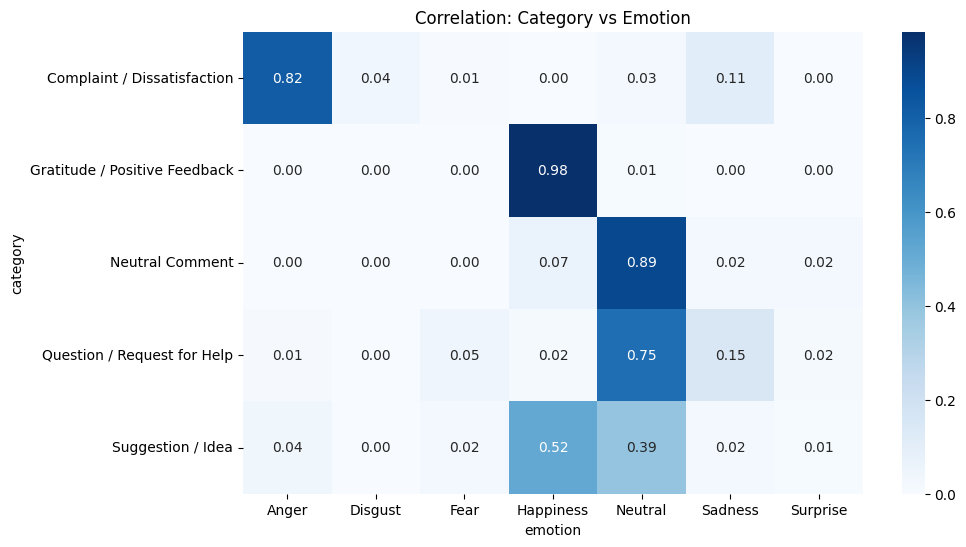


Rules
Rule: Category 'Gratitude / Positive Feedback' -> Emotion 'Happiness' (Conf: 98.39%)


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('/kaggle/input/nlp-lab2-data/emotions/train.csv').fillna("")

crosstab = pd.crosstab(train['category'], train['emotion'])
print("Raw Counts:")
print(crosstab)

# "Given Category X, what is the probability of Emotion Y?" as I wanted to analyze how categories influence emotuions
prob_matrix = crosstab.div(crosstab.sum(axis=1), axis=0)
print("\nConditional Probabilities (Rules):")
print(prob_matrix.round(3))

plt.figure(figsize=(10,6))
sns.heatmap(prob_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title("Correlation: Category vs Emotion")
plt.show()

# I operate on rules, if some emotions is more than 95% probable under some category, we just fix that
print("\nRules")
for cat in prob_matrix.index:
    for emo in prob_matrix.columns:
        prob = prob_matrix.loc[cat, emo]
        if prob > 0.95:
            print(f"Rule: Category '{cat}' -> Emotion '{emo}' (Conf: {prob:.2%})")

In [9]:
MODEL_NAME = "xlm-roberta-large" 
MAX_LEN = 128
SEED = 42
BATCH_SIZE = 8          
EPOCHS = 4
LR = 2e-4               

np.random.seed(SEED)
torch.manual_seed(SEED)

train_df = pd.read_csv("/kaggle/input/nlp-lab2-data/emotions/train.csv").fillna("")
test_df = pd.read_csv("/kaggle/input/nlp-lab2-data/emotions/test.csv").fillna("")

train_df['text'] = train_df['text'].str.replace('\n', ' ', regex=False)
test_df['text'] = test_df['text'].str.replace('\n', ' ', regex=False)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
sep_token = tokenizer.sep_token

# I oversample because there is not much examples of fear and sadness and similar
def oversample_data(df, target_col):
    df = df.copy()
    counts = df[target_col].value_counts()
    max_count = counts.max()
    frames = []
    for label, count in counts.items():
        subset = df[df[target_col] == label]
        if count < (max_count * 0.2): 
            target_count = int(max_count * 0.3) 
            if count == 0: continue
            n_repeat = (target_count // count)
            if n_repeat > 1:
                subset = pd.concat([subset] * n_repeat, ignore_index=True)
                subset = subset.sample(n=target_count, replace=True, random_state=SEED)
        frames.append(subset)
    return pd.concat(frames).sample(frac=1, random_state=SEED).reset_index(drop=True)

def process_data(df, label_map, text_col="text", target_col=None):
    if target_col:
        df['label'] = df[target_col].map(label_map['label2id'])
    dataset = Dataset.from_pandas(df)
    def tokenize(examples):
        return tokenizer(examples[text_col], truncation=True, max_length=MAX_LEN)
    tokenized = dataset.map(tokenize, batched=True)
    cols = ['input_ids', 'attention_mask']
    if target_col: cols.append('label')
    tokenized = tokenized.remove_columns([c for c in tokenized.column_names if c not in cols])
    tokenized.set_format("torch")
    return tokenized

def train_full_data(target_col, input_text_col, save_name):
    print(f"\n{'='*40}\nTrain start {target_col.upper()}\n{'='*40}")
    
    unique_labels = np.unique(train_df[target_col])
    label_map = {
        'id2label': {i: l for i, l in enumerate(unique_labels)},
        'label2id': {l: i for i, l in enumerate(unique_labels)}
    }
    train_balanced = oversample_data(train_df, target_col)
    
    ds_train = process_data(train_balanced, label_map, text_col=input_text_col, target_col=target_col)
    ds_test = process_data(test_df, label_map, text_col=input_text_col, target_col=None)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(unique_labels),
        id2label=label_map['id2label'], label2id=label_map['label2id']
    )

    # Lora parameters were picked experimentally, you can see the story submission on kaggle:)
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["query", "value"]
    )
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    
    args = TrainingArguments(
        output_dir=f"res_{save_name}",
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE*2,
        gradient_accumulation_steps=2,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        save_strategy="no",
        eval_strategy="no",
        fp16=True,
        report_to="none"
    )
    
    trainer = Trainer(
        model=model, args=args, train_dataset=ds_train, 
        tokenizer=tokenizer, data_collator=DataCollatorWithPadding(tokenizer)
    )
    
    trainer.train()
    
    print(f"Processing {target_col}")
    logits = trainer.predict(ds_test).predictions
    preds = np.argmax(logits, axis=1)
    final_preds = [label_map['id2label'][i] for i in preds]
    
    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()
    shutil.rmtree(f"res_{save_name}", ignore_errors=True)
    
    return final_preds

# Category
final_categories = train_full_data(
    target_col='category', 
    input_text_col='text', 
    save_name='cat_full'
)

# I inject context to train emotiuon on as well as context is highly dependent on emotion
train_df['context_text'] = train_df['category'] + f" {sep_token} " + train_df['text']
test_df['predicted_category'] = final_categories
test_df['context_text'] = test_df['predicted_category'] + f" {sep_token} " + test_df['text']

# Emotion
final_emotions = train_full_data(
    target_col='emotion', 
    input_text_col='context_text', 
    save_name='emo_full'
)

submission = pd.DataFrame({
    'index': test_df['index'] if 'index' in test_df.columns else test_df.index,
    'emotion': final_emotions,
    'category': final_categories
})

# A SILLY FIX, i FOUND OUT THAT FIXING HALLUCINATIONS THIS WAY FOR EMOTIONS ONLY IS BENEFICIENT to the final score.
submission.loc[submission['category'] == 'Gratitude / Positive Feedback', 'emotion'] = 'Happiness'

submission.to_csv('submission_final_100_percent.csv', index=False)
print("Done u won")

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]


Train start CATEGORY


Map:   0%|          | 0/11817 [00:00<?, ? examples/s]

Map:   0%|          | 0/3474 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_173/3224147257.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


trainable params: 1,841,157 || all params: 561,736,714 || trainable%: 0.3278


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.525500
1000,0.169900


Processing category



Train start EMOTION


Map:   0%|          | 0/14810 [00:00<?, ? examples/s]

Map:   0%|          | 0/3474 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_173/3224147257.py:95: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


trainable params: 1,843,207 || all params: 561,740,814 || trainable%: 0.3281


No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
500,0.696300
1000,0.198400
1500,0.125800


Processing emotion


Done u won


# Other
Here are other submissions, I did not run them as they were completed over like 3 days do doing a one big final rerun would be terrible. Also the code there is bad as I was prototyping.

## ukr-roberta-base with weighted inclusion of class imbalance
Result: 0.62

In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
MODEL_NAME = "youscan/ukr-roberta-base"

train_df = pd.read_csv("/kaggle/input/nlp-lab2-data/emotions/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-lab2-data/emotions/test.csv")

targets = ['emotion', 'category']
label_maps = {} 
class_weights_dict = {}

for target in targets:
    unique_labels = np.unique(train_df[target])
    label_maps[target] = {
        'id2label': {i: label for i, label in enumerate(unique_labels)},
        'label2id': {label: i for i, label in enumerate(unique_labels)}
    }
    
    # Calculate Weights: rare classes get higher weights
    weights = compute_class_weight(
        class_weight="balanced", 
        classes=unique_labels, 
        y=train_df[target]
    )
    class_weights_dict[target] = torch.tensor(weights, dtype=torch.float32)
    print(f"Weights for {target}:\n{weights}")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def process_data(df, target_col=None):
    if target_col:
        df['label'] = df[target_col].map(label_maps[target_col]['label2id'])
    
    dataset = Dataset.from_pandas(df)
    
    def tokenize(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    tokenized = dataset.map(tokenize, batched=True)
    
    # Clean columns
    cols = ['input_ids', 'attention_mask', 'label'] if target_col else ['input_ids', 'attention_mask']
    tokenized = tokenized.remove_columns([c for c in tokenized.column_names if c not in cols])
    
    if target_col:
        tokenized.set_format("torch")
    return tokenized


class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        if self.class_weights is not None:
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss = outputs.get("loss")
        return (loss, outputs) if return_outputs else loss

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"f1_macro": f1_score(labels, predictions, average="macro")}


def train_target(target_col):
    print(f"\n{'='*10} Training {target_col} {'='*10}")

    train_split, val_split = train_test_split(
        train_df, test_size=0.15, random_state=SEED, stratify=train_df[target_col]
    )
    
    ds_train = process_data(train_split, target_col)
    ds_val = process_data(val_split, target_col)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, 
        num_labels=len(label_maps[target_col]['label2id']),
        id2label=label_maps[target_col]['id2label'],
        label2id=label_maps[target_col]['label2id']
    )
    
    args = TrainingArguments(
        output_dir=f"./results_{target_col}",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=6,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        save_total_limit=2,
        fp16=True,
        report_to="none"
    )
    
    trainer = WeightedTrainer(
        class_weights=class_weights_dict[target_col],
        model=model,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # Stop if score doesn't improve
    )
    
    trainer.train()
    return trainer

trainer_emo = train_target('emotion')
trainer_cat = train_target('category')

print("\nGenerating predictions")
ds_test = process_data(test_df, target_col=None)

preds_emo = np.argmax(trainer_emo.predict(ds_test).predictions, axis=1)
labels_emo = [label_maps['emotion']['id2label'][i] for i in preds_emo]

preds_cat = np.argmax(trainer_cat.predict(ds_test).predictions, axis=1)
labels_cat = [label_maps['category']['id2label'][i] for i in preds_cat]

sub = pd.DataFrame({'index': test_df['index'] if 'index' in test_df else test_df.index, 'emotion': labels_emo, 'category': labels_cat})
sub.to_csv('submission_weighted.csv', index=False)

## mdeberta-base with oversampling and weighted cross-entropy
Result: 0.65

In [ ]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from datasets import Dataset

SEED = 42
MODEL_NAME = "microsoft/mdeberta-v3-base" 
MAX_LEN = 128

np.random.seed(SEED)
torch.manual_seed(SEED)

train_df = pd.read_csv("/kaggle/input/nlp-lab2-data/emotions/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-lab2-data/emotions/test.csv")

targets = ['emotion', 'category']
label_maps = {} 
class_weights_dict = {}

for target in targets:
    unique_labels = np.unique(train_df[target])
    label_maps[target] = {
        'id2label': {i: label for i, label in enumerate(unique_labels)},
        'label2id': {label: i for i, label in enumerate(unique_labels)}
    }
    
                               
    weights = compute_class_weight(
        class_weight="balanced", 
        classes=unique_labels, 
        y=train_df[target]
    )
    class_weights_dict[target] = torch.tensor(weights, dtype=torch.float32)
    print(f"Weights for {target}: {weights}")

         
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def process_data(df, target_col=None):
    if target_col:
        df['label'] = df[target_col].map(label_maps[target_col]['label2id'])
    
    dataset = Dataset.from_pandas(df)
    
    def tokenize(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=MAX_LEN)

    tokenized = dataset.map(tokenize, batched=True)
    
 
    cols = ['input_ids', 'attention_mask', 'label'] if target_col else ['input_ids', 'attention_mask']
    tokenized = tokenized.remove_columns([c for c in tokenized.column_names if c not in cols])
    
    if target_col:
        tokenized.set_format("torch")
    return tokenized

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"f1_macro": f1_score(labels, predictions, average="macro")}

class WeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights.to(self.args.device) if class_weights is not None else None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        if self.class_weights is not None:
            # Weighted Cross Entropy:)
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights)
            loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        else:
            loss = outputs.get("loss")
            
        return (loss, outputs) if return_outputs else loss

def train_target(target_col):
    print(f"\n{'='*10} Training {target_col} (mDeBERTa) {'='*10}")
    
    # Stratified Split
    train_split, val_split = train_test_split(
        train_df, test_size=0.15, random_state=SEED, stratify=train_df[target_col]
    )
    
    ds_train = process_data(train_split, target_col)
    ds_val = process_data(val_split, target_col)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, 
        num_labels=len(label_maps[target_col]['label2id']),
        id2label=label_maps[target_col]['id2label'],
        label2id=label_maps[target_col]['label2id']
    )
    
    # HYPERPARAMETERS V3
    training_args = TrainingArguments(
        output_dir=f"./results_{target_col}",
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=16,
        gradient_accumulation_steps=2,
        num_train_epochs=5,
        weight_decay=0.05
        label_smoothing_factor=0.1,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        save_total_limit=1,
        fp16=True,
        report_to="none"
    )
    
    trainer = WeightedTrainer(
        class_weights=class_weights_dict[target_col],
        model=model,
        args=training_args,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    
    trainer.train()
    return trainer

trainer_emo = train_target('emotion')
trainer_cat = train_target('category')

print("\nGenerating predictions")
ds_test = process_data(test_df, target_col=None)

preds_emo = np.argmax(trainer_emo.predict(ds_test).predictions, axis=1)
preds_cat = np.argmax(trainer_cat.predict(ds_test).predictions, axis=1)

labels_emo = [label_maps['emotion']['id2label'][i] for i in preds_emo]
labels_cat = [label_maps['category']['id2label'][i] for i in preds_cat]

if 'index' in test_df.columns:
    ids = test_df['index']
else:
    ids = test_df.index

sub = pd.DataFrame({
    'index': ids,
    'emotion': labels_emo,
    'category': labels_cat
})

sub.to_csv('submission_mdeberta.csv', index=False)

## xlm-roberta-large + oversampling + lora + 10% validation
Result: 0.69

In [ ]:

import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    TrainingArguments, 
    Trainer,
    DataCollatorWithPadding,
    EarlyStoppingCallback
)
from peft import get_peft_model, LoraConfig, TaskType
from datasets import Dataset
import gc
import shutil
import os

MODEL_NAME = "xlm-roberta-large" 
MAX_LEN = 128
SEED = 42
BATCH_SIZE = 8 
EPOCHS = 4
LR = 2e-4             


np.random.seed(SEED)
torch.manual_seed(SEED)

train_df = pd.read_csv("/kaggle/input/nlp-lab2-data/emotions/train.csv").fillna("")
test_df = pd.read_csv("/kaggle/input/nlp-lab2-data/emotions/test.csv").fillna("")

train_df['text'] = train_df['text'].str.replace('\n', ' ', regex=False)
test_df['text'] = test_df['text'].str.replace('\n', ' ', regex=False)

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
sep_token = tokenizer.sep_token

def oversample_data(df, target_col):
    df = df.copy()
    counts = df[target_col].value_counts()
    max_count = counts.max()
    frames = []
    for label, count in counts.items():
        subset = df[df[target_col] == label]
        if count < (max_count * 0.2): 
            target_count = int(max_count * 0.3) 
            if count == 0: continue
            n_repeat = (target_count // count)
            if n_repeat > 1:
                subset = pd.concat([subset] * n_repeat, ignore_index=True)
                subset = subset.sample(n=target_count, replace=True, random_state=SEED)
        frames.append(subset)
    return pd.concat(frames).sample(frac=1, random_state=SEED).reset_index(drop=True)

def process_data(df, label_map, text_col="text", target_col=None):
    if target_col:
        df['label'] = df[target_col].map(label_map['label2id'])
    dataset = Dataset.from_pandas(df)
    
    def tokenize(examples):
        return tokenizer(examples[text_col], truncation=True, max_length=MAX_LEN)
    
    tokenized = dataset.map(tokenize, batched=True)
    cols = ['input_ids', 'attention_mask']
    if target_col: cols.append('label')
    tokenized = tokenized.remove_columns([c for c in tokenized.column_names if c not in cols])
    tokenized.set_format("torch")
    return tokenized

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"f1_macro": f1_score(labels, predictions, average="macro")}

def train_lora_model(target_col, input_text_col, save_name):
    print(f"\n{'='*40}\nTRAINING {target_col.upper()} MODEL (LoRA)\n{'='*40}")
    
    unique_labels = np.unique(train_df[target_col])
    label_map = {
        'id2label': {i: l for i, l in enumerate(unique_labels)},
        'label2id': {l: i for i, l in enumerate(unique_labels)}
    }
    
    train_split, val_split = train_test_split(
        train_df, test_size=0.1, random_state=SEED, stratify=train_df[target_col]
    )
    
    train_balanced = oversample_data(train_split, target_col)
    
    ds_train = process_data(train_balanced, label_map, text_col=input_text_col, target_col=target_col)
    ds_val = process_data(val_split, label_map, text_col=input_text_col, target_col=target_col)
    ds_test = process_data(test_df, label_map, text_col=input_text_col, target_col=None)
    
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME, num_labels=len(unique_labels),
        id2label=label_map['id2label'], label2id=label_map['label2id']
    )
    
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        inference_mode=False,
        r=8,
        lora_alpha=16,
        lora_dropout=0.1,
        target_modules=["query", "value"]
    )
    model = get_peft_model(model, peft_config)
    model.print_trainable_parameters()
    
    args = TrainingArguments(
        output_dir=f"res_{save_name}",
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE*2,
        gradient_accumulation_steps=2,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        save_total_limit=1,
        fp16=True,
        report_to="none"
    )
    
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    
    trainer.train()
    
    print(f"Predicting {target_col} on Test Set")
    logits = trainer.predict(ds_test).predictions
    preds_idx = np.argmax(logits, axis=1)
    final_preds = [label_map['id2label'][i] for i in preds_idx]
    
    # Cleanup
    del model, trainer
    gc.collect()
    torch.cuda.empty_cache()
    shutil.rmtree(f"res_{save_name}", ignore_errors=True)
    
    return final_preds


final_categories = train_lora_model(
    target_col='category', 
    input_text_col='text', 
    save_name='cat_lora'
)

print("\nPreparing Context for Emotion Model")
train_df['context_text'] = train_df['category'] + f" {sep_token} " + train_df['text']

test_df['predicted_category'] = final_categories
test_df['context_text'] = test_df['predicted_category'] + f" {sep_token} " + test_df['text']

print(f"Sample Train Context: {train_df['context_text'].iloc[0]}")
print(f"Sample Test Context:  {test_df['context_text'].iloc[0]}")

final_emotions = train_lora_model(
    target_col='emotion', 
    input_text_col='context_text', 
    save_name='emo_lora'
)

submission = pd.DataFrame({
    'index': test_df['index'] if 'index' in test_df.columns else test_df.index,
    'emotion': final_emotions,
    'category': final_categories
})

submission.loc[submission['category'] == 'Gratitude / Positive Feedback', 'emotion'] = 'Happiness'

submission.to_csv('submission_xlmr_large_cascade.csv', index=False)